In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import scipy as sp
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

# Simulation parameters
Nparts, Nturns =  20000, 1201 
betPU, alfPU    =  1.3, -0.9
betK, alfK      =  0.8,  0.6
gamPU, gamK     =  (1 + alfPU**2)/betPU, (1 + alfK**2)/betK
muPUK, muKPU    =  1.51, 2*np.pi*1.34 - 1.51
total_angle     =  2*np.pi*1.34
etaPUK, etaKPU  =  -0.01, -0.01
sigdelt         =  0.004
Th, Trev        =  (620.6e-9)/2, 620.6e-9
Tovlap          = 4 * sigdelt * abs(etaPUK + etaKPU) * Trev
NSamp           = 800
add             = '2000'

# Sampling
over_sample_factor = 10
DTSamp = Th / NSamp
NSampext = math.ceil(Tovlap / DTSamp)
inds = np.arange((-NSampext)*over_sample_factor, (NSamp + 1 + NSampext + 1)*over_sample_factor)
t_bins = inds * DTSamp / over_sample_factor - Th / 2
wlL, wrL = -1.6e-9, 1.6e-9
wlH, wrH = -1.6e-9, 1.6e-9

def exp_decay(x, A, B, C):
    return A * np.exp(-B * x) + C

def running_average(x, y, bins):
    x = np.array(x)
    y = np.array(y)
    bin_indices = np.digitize(x, bins) - 1
    valid = (bin_indices > 0) & (bin_indices < len(bins) - 1)
    averages = np.zeros(len(bins) - 1, dtype=float)
    bin_sums = np.bincount(bin_indices[valid], minlength=len(bins) - 1, weights=y[valid])
    bin_counts = np.bincount(bin_indices[valid], minlength=len(bins) - 1)
    non_empty = bin_counts > 0
    averages[non_empty] = bin_sums[non_empty] / bin_counts[non_empty]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    return bin_centers, averages, bin_counts, bin_sums

def respH(Dt):
    return (1 - 27e18*Dt**2)*(1 - 3.e18*Dt**2)*(1 - 1.15e18*Dt**2)*(1 - (.625e9*Dt)**2)**7

def respL(Dt):
    return (63e9*Dt)*(1 - 6.5e18*Dt**2)*(1 - 1.55e18*Dt**2)*(1 - (.625e9*Dt)**2)**8

respH_new_once = respH(np.arange(wlH, wrH, DTSamp/over_sample_factor))
respL_new_once = respL(np.arange(wlL, wrL, DTSamp/over_sample_factor))

def PartsExchange(ptsEarly, ptsLate, Th):
    ptsEarlyNew, ptsLateNew = [], []
    for x, xp, delt, Tau in ptsEarly:
        if Tau < Th/2:
            ptsEarlyNew.append([x, xp, delt, Tau])
        else:
            ptsLateNew.append([x, xp, delt, Tau - Th])
    for x, xp, delt, Tau in ptsLate:
        if Tau > -Th/2:
            ptsLateNew.append([x, xp, delt, Tau])
        else:
            ptsEarlyNew.append([x, xp, delt, Tau + Th])
    return ptsEarlyNew, ptsLateNew

def TimeTraces(ptsEarly, ptsMain, ptsLate, bins, Th):
    ptsEarly = np.array(ptsEarly)
    ptsMain = np.array(ptsMain)
    ptsLate = np.array(ptsLate)
    bin_centers_early, _, count_early, sum_early = running_average(ptsEarly[:, 3] - Th, ptsEarly[:, 0], bins)
    bin_centers_main, _, count_main, sum_main = running_average(ptsMain[:, 3], ptsMain[:, 0], bins)
    bin_centers_late, _, count_late, sum_late = running_average(ptsLate[:, 3] + Th, ptsLate[:, 0], bins)
    TraceH_early = np.convolve(respH_new_once, sum_early, 'same')
    TraceH_main  = np.convolve(respH_new_once, sum_main,  'same')
    TraceH_late  = np.convolve(respH_new_once, sum_late,  'same')
    TraceL_early = np.convolve(respL_new_once, count_early, 'same')
    TraceL_main  = np.convolve(respL_new_once, count_main,  'same')
    TraceL_late  = np.convolve(respL_new_once, count_late,  'same')
    TraceH = TraceH_early + TraceH_main + TraceH_late
    TraceL = TraceL_early + TraceL_main + TraceL_late
    return bin_centers_main, TraceH, TraceL

def kickH(pts, signalH):
    corrected = []
    for x, xp, delt, Tau in pts:
        corrected_xp = xp + gain * signalH(Tau)
        corrected.append([x, corrected_xp, delt, Tau])
    return corrected

def kickL(pts, signalL):
    corrected = []
    for x, xp, delt, Tau in pts:
        corrected_delt = delt + gainL * signalL(Tau)
        corrected.append([x, xp, corrected_delt, Tau])
    return corrected

def Cooling(gain, gainL):
    # definition of the transverse "response function", which is given by the 
    # routine resp for the interval -wlH < Dt < wrH and 0 outside

    print('========>', NSamp, NSampext, DTSamp, Th, (wrH - wlH)/DTSamp)

    # Computation of transverse transfer matrix elements
    projPU11 =  betPU**(1/2)
    projPU21 = -alfPU/betPU**(1/2)
    projPU22 =  1/betPU**(1/2)

    matPUK11 = ((betK/betPU)**(1/2))*(np.cos(muPUK) + alfPU*np.sin(muPUK))
    matPUK12 = ((betPU*betK)**(1/2))*np.sin(muPUK)
    matPUK21 = ((alfPU-alfK)*np.cos(muPUK) - (1+alfPU*alfK)*np.sin(muPUK))/((betPU*betK)**(1/2))
    matPUK22 = ((betPU/betK)**(1/2))*(np.cos(muPUK) - alfK*np.sin(muPUK))

    matKPU11 = ((betPU/betK)**(1/2))*(np.cos(muKPU) + alfK*np.sin(muKPU))
    matKPU12 = ((betPU*betK)**(1/2))*np.sin(muKPU)
    matKPU21 = ((alfK-alfPU)*np.cos(muKPU) - (1+alfPU*alfK)*np.sin(muKPU))/((betPU*betK)**(1/2))
    matKPU22 = ((betK/betPU)**(1/2))*(np.cos(muKPU) - alfPU*np.sin(muKPU))

    # Generate macroparticles in two groups with red ones and blue ones
    ptsRed = []
    ptsBlue = []
    a, b = -3, 3
    for _ in range(Nparts):
        Tau = rng.uniform(-Th, Th)
        xn, xpn = rng.normal(0., 1.), rng.normal(0., 1.)
        deltn = rng.normal(0., 1.)
        while abs(deltn) > 3.:
            deltn = rng.normal(0., 1.)
        if Tau < 0:
            ptsRed += [[projPU11*xn, projPU21*xn + projPU22*xpn, deltn*sigdelt, Tau + Th/2]]
        else:
            ptsBlue += [[projPU11*xn, projPU21*xn + projPU22*xpn, deltn*sigdelt, Tau - Th/2]]

    # Initial statistics
    emittance = np.zeros(Nturns+2)
    geo_emittance = np.zeros(Nturns+2)
    rms_momentum_spread = np.zeros(Nturns+2)
    beam = np.array(ptsRed + ptsBlue)
    x_beam = beam[:, 0]
    xp_beam = beam[:, 1]
    tau_initial = beam[:, 3]
    delt_initial = beam[:, 2]
    emittance[0] = np.sqrt(np.mean(x_beam**2)*np.mean(xp_beam**2)-np.mean(x_beam*xp_beam)**2)
    geo_emittance[0] = ((gamPU*np.mean(x_beam**2)+2*alfPU*np.mean(x_beam*xp_beam)+betPU*np.mean(xp_beam**2)))/2
    rms_momentum_spread[0] = np.sqrt(np.mean(delt_initial**2)-np.mean(delt_initial)**2)

    # Initial tracking
    ptsRedprev = ptsRed
    ptsRed = [
        [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, Tau + etaPUK*delt*Trev]
        for x, xp, delt, Tau in ptsRed
    ]
    ptsRed = [
        [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, Tau + etaKPU*delt*Trev]
        for x, xp, delt, Tau in ptsRed
    ]

    ptsBlue, ptsRed = PartsExchange(ptsBlue, ptsRed, Th)
    ptsBlueprev = ptsBlue
    time2, TrHBlue, TrLBlue = TimeTraces(ptsRedprev, ptsBlue, ptsRed, t_bins, Th)

    ptsBlue = [
        [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, Tau + etaPUK*delt*Trev]
        for x, xp, delt, Tau in ptsBlue
    ]
    ptsBlue = [
        [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, Tau + etaKPU*delt*Trev]
        for x, xp, delt, Tau in ptsBlue
    ]
    TrHBlue_prev, TrLBlue_prev = TrHBlue, TrLBlue

    ptsRed, ptsBlue = PartsExchange(ptsRed, ptsBlue, Th)
    ptsRedprev = ptsRed
    time2, TrHRed, TrLRed = TimeTraces(ptsBlueprev, ptsRed, ptsBlue, t_bins, Th)
    ptsRed = [
        [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, Tau + etaPUK*delt*Trev]
        for x, xp, delt, Tau in ptsRed
    ]
    ptsRed = [
        [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, Tau + etaKPU*delt*Trev]
        for x, xp, delt, Tau in ptsRed
    ]
    TrHRed_prev, TrLRed_prev = TrHRed, TrLRed

    # Record stats again
    beam = np.array(ptsRed + ptsBlue)
    x_beam = beam[:, 0]
    xp_beam = beam[:, 1]
    dtl_beam = beam[:, 2]
    emittance[1] = np.sqrt(np.mean(x_beam**2)*np.mean(xp_beam**2)-np.mean(x_beam*xp_beam)**2)
    rms_momentum_spread[1] = np.sqrt(np.mean(dtl_beam**2)-np.mean(dtl_beam)**2)
    turn50 = 0

    for turn in range(Nturns):
        ptsBlue, ptsRed = PartsExchange(ptsBlue, ptsRed, Th)
        ptsBlueprev, TrLBlueprev = ptsBlue, TrLBlue
        time2, TrHBlue, TrLBlue = TimeTraces(ptsRedprev, ptsBlue, ptsRed, t_bins, Th)
        TrLDiffBlue = [h - l for h, l in zip(TrLBlue_prev, TrLBlue)]
        cs = sp.interpolate.CubicSpline(time2, TrHBlue)
        csL = sp.interpolate.CubicSpline(time2, np.array(TrLDiffBlue))
        ptsBlue = [
            [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, Tau + etaPUK*delt*Trev]
            for x, xp, delt, Tau in ptsBlue
        ]
        ptsBlue = kickH(ptsBlue, cs)
        ptsBlue = kickL(ptsBlue, csL)
        ptsBlue = [
            [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, Tau + etaKPU*delt*Trev]
            for x, xp, delt, Tau in ptsBlue
        ]
        TrHBlue_prev, TrLBlue_prev = TrHBlue, TrLBlue

        ptsRed, ptsBlue = PartsExchange(ptsRed, ptsBlue, Th)
        ptsRedprev, TrLRedprev = ptsRed, TrLRed
        time2, TrHRed, TrLRed = TimeTraces(ptsBlueprev, ptsRed, ptsBlue, t_bins, Th)
        TrLDiffRed = [h - l for h, l in zip(TrLRed_prev, TrLRed)]
        cs = sp.interpolate.CubicSpline(time2, TrHRed)
        csL = sp.interpolate.CubicSpline(time2, np.array(TrLDiffRed))
        ptsRed = [
            [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, Tau + etaPUK*delt*Trev]
            for x, xp, delt, Tau in ptsRed
        ]
        ptsRed = kickH(ptsRed, cs)
        ptsRed = kickL(ptsRed, csL)
        ptsRed = [
            [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, Tau + etaKPU*delt*Trev]
            for x, xp, delt, Tau in ptsRed
        ]
        TrHRed_prev, TrLRed_prev = TrHRed, TrLRed

        beam = np.array(ptsRed + ptsBlue)
        x_beam = beam[:, 0]
        xp_beam = beam[:, 1]
        delta_beam = beam[:, 2]
        emittance[turn+2] = np.sqrt(np.mean(x_beam**2)*np.mean(xp_beam**2)-np.mean(x_beam*xp_beam)**2)
        geo_emittance[turn+2] = (gamPU*np.mean(x_beam**2)+2*alfPU*np.mean(x_beam*xp_beam)+betPU*np.mean(xp_beam**2))/2
        rms_momentum_spread[turn+2] = np.sqrt(np.mean(delta_beam**2)-np.mean(delta_beam)**2)

        if emittance[turn+2] <= emittance[0]/2 and turn50 == 0:
            turn50 = turn+1
        if turn == 19:
            rms_20 = emittance[turn+2]
        if turn == 49:
            rms_50 = emittance[turn+2]
        if turn == 99:
            rms_100 = emittance[turn+2]

    x_data = np.linspace(0, Nturns, Nturns)
    y_data = emittance[2:]
    initial_guess = [y_data[0], 0.001, min(y_data)]
    params, covariance = curve_fit(exp_decay, x_data, y_data, p0=initial_guess, maxfev=5000)
    A_fit, B_fit, C_fit = params
    tau_longitudinal_cooling = 1 / B_fit
    tau_L_real = tau_longitudinal_cooling * Trev

    print(f"Cooling time (τ) for emittance: {tau_L_real:.6f} sec")
    print(f'The initial emittance is {emittance[0]}π mm*mrad')
    print(f'The final emittance after cooling is {emittance[-1]}π mm*mrad')
    print(f'Is emittance reduced? -->  {emittance[-1] < emittance[0]}')
    if emittance[-1] < emittance[0]:
        print(f"Emittance is reduced by {(emittance[0] - emittance[-1]) * 100 / emittance[0]}%")
    print(f'The initial rms_momentum_spread is {rms_momentum_spread[0]} ')
    print(f'The final rms_momentum_spread after cooling is {rms_momentum_spread[-1]} ')
    print(f'Is rms_momentum_spread reduced? -->  {rms_momentum_spread[-1] < rms_momentum_spread[0]}')
    if rms_momentum_spread[-1] < rms_momentum_spread[0]:
        print(f"rms_momentum_spread is reduced by {(rms_momentum_spread[0] - rms_momentum_spread[-1]) * 100 / rms_momentum_spread[0]}%")

    return emittance[-1], rms_20, rms_50, rms_100, turn50, tau_L_real


<>:865: SyntaxWarning: invalid escape sequence '\d'
<>:865: SyntaxWarning: invalid escape sequence '\d'
/tmp/vtsianti/ipykernel_1566966/1117966795.py:865: SyntaxWarning: invalid escape sequence '\d'
  '''


Sampling rate: 1.2412e-10 s
inds 25060
Number of bins: 25059 Average particles per bin: 0.07981164451893531
========> 2500 2 1.2412e-10 3.103e-07 25.781501772478247
Total particles in beam: 2000
Particles binned this turn: 2997
The initial emittance is 0.9710517579575508π mm*mrad
The final emittance after cooling is 0.10603483984622064π mm*mrad
Is emittance reduced? -->  True
Emittance is reduced by 89.0804131729036%
The initial rms_momentum_spread is 0.003956970257534903 
The final rms_momentum_spread after cooling is 0.003956970257534903 
Is rms_momentum_spread reduced? -->  False


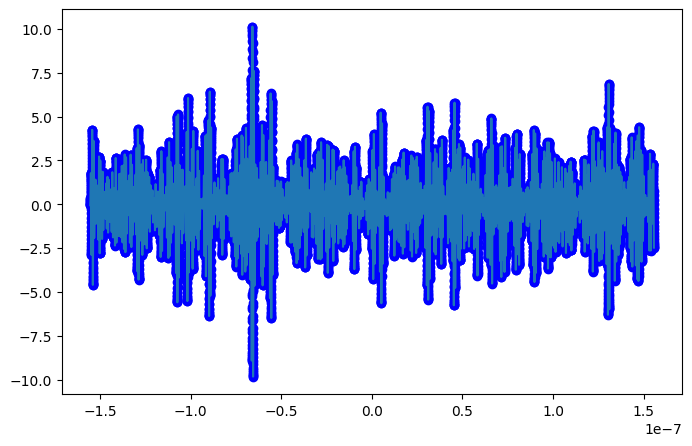

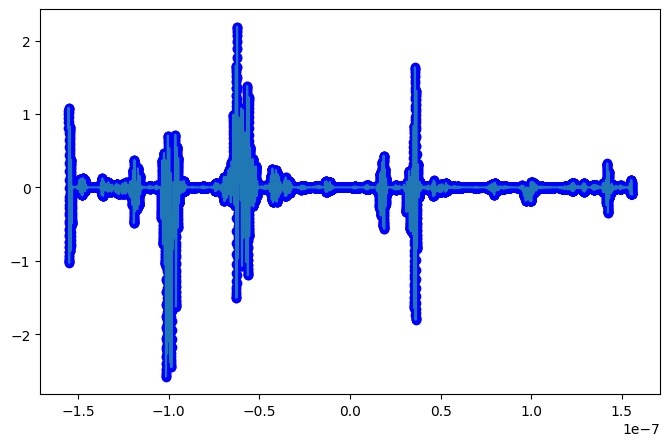

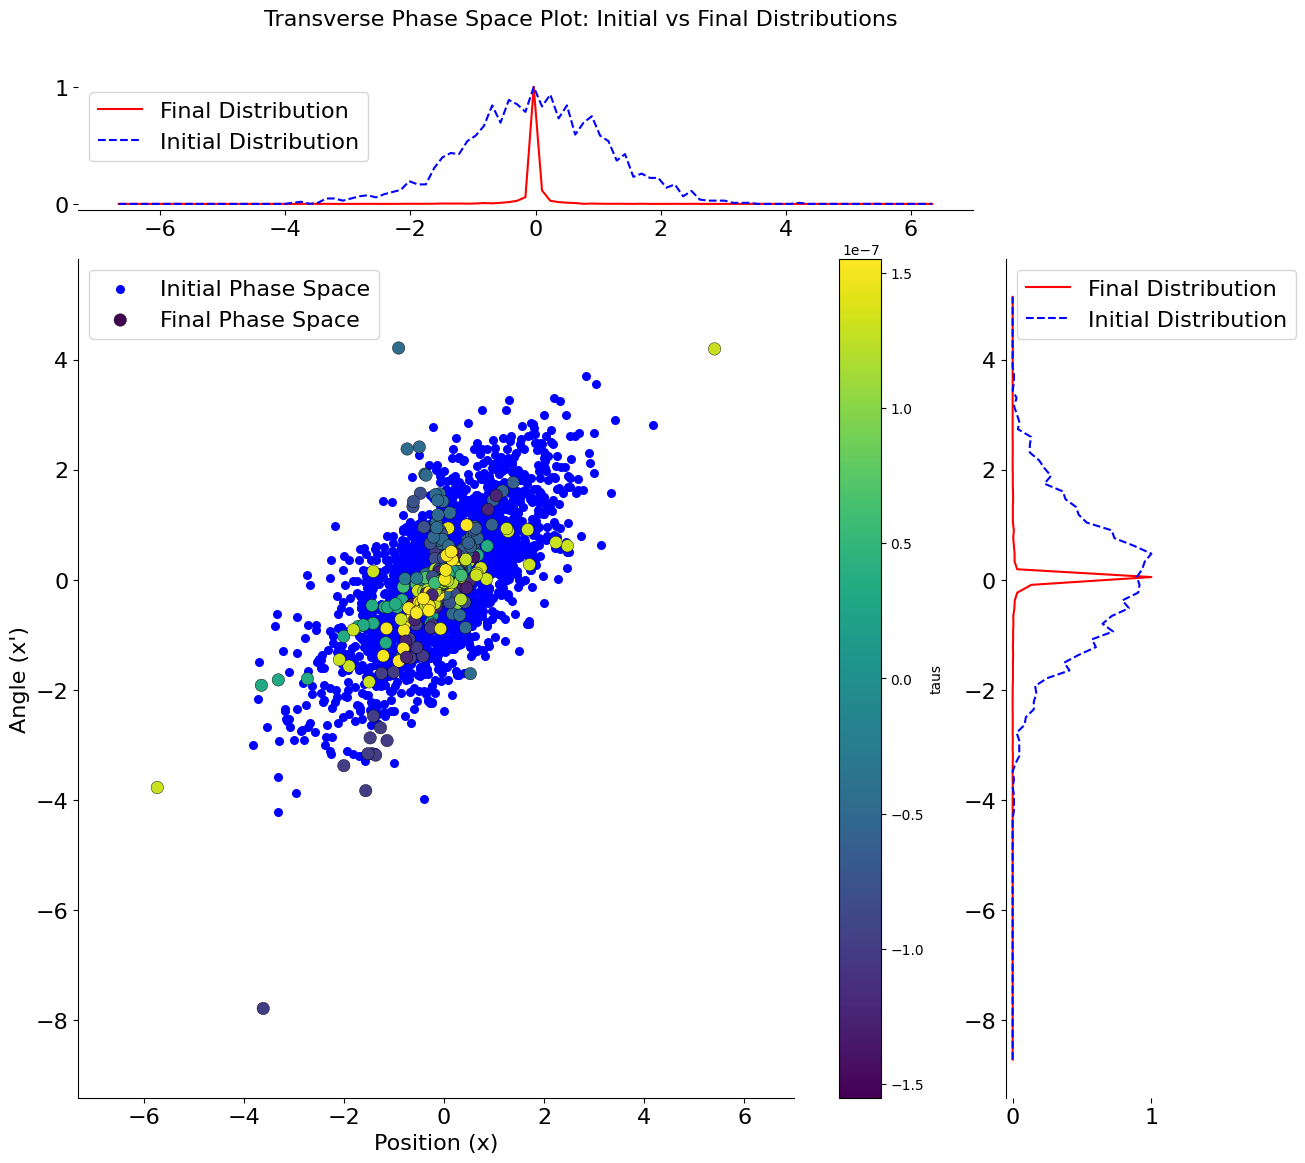

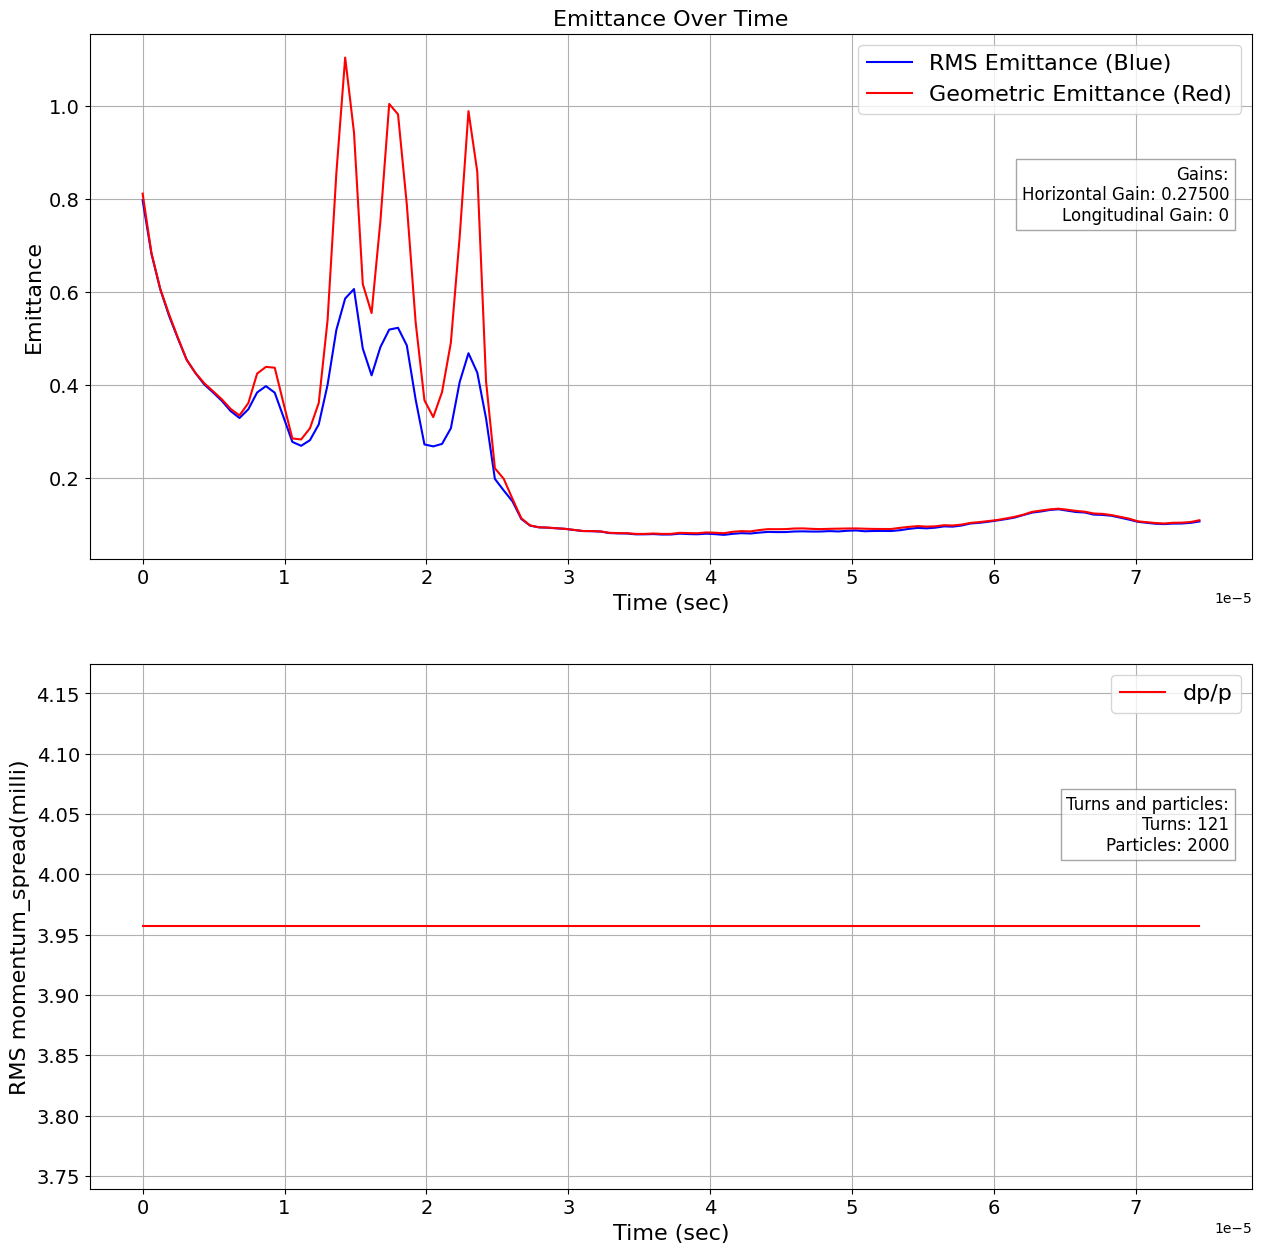

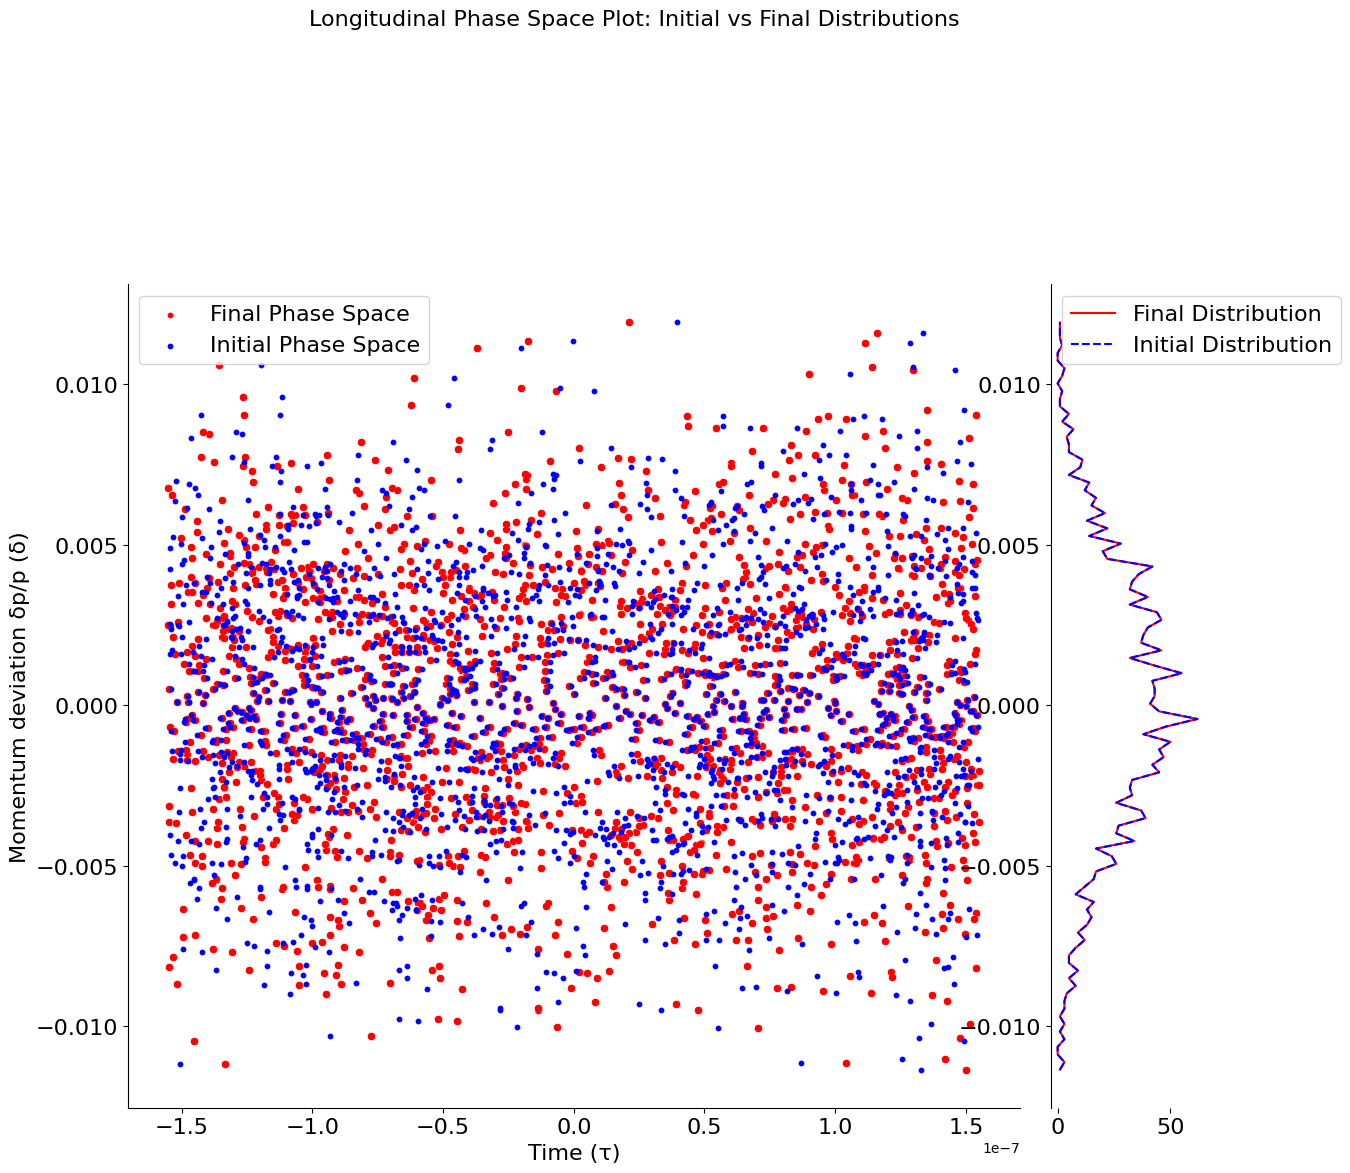

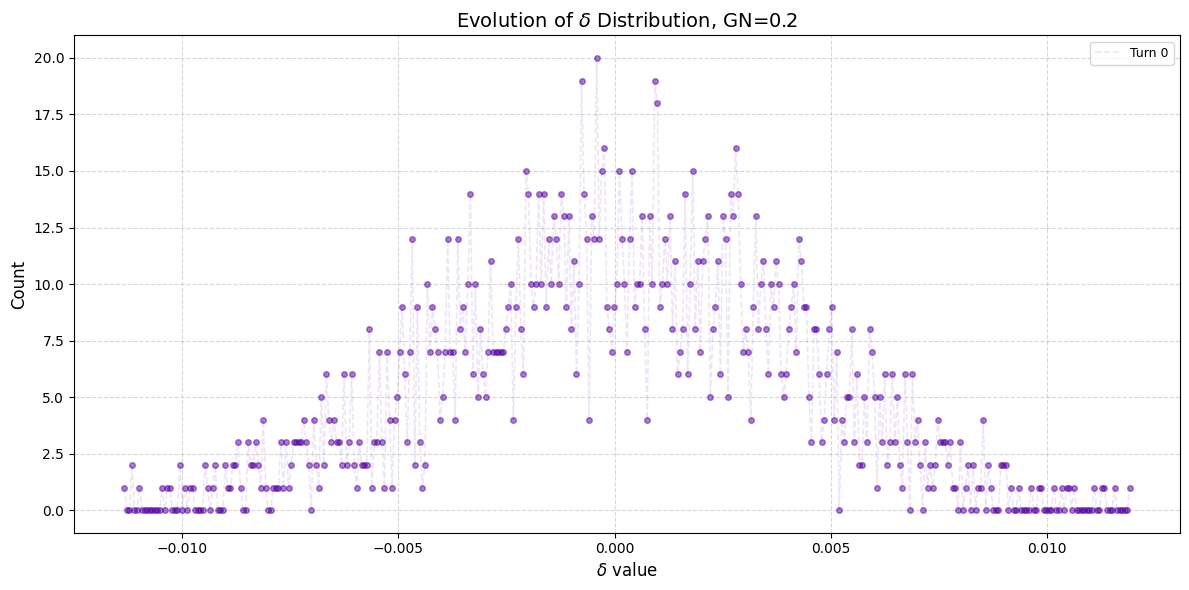

/tmp/vtsianti/ipykernel_1566966/1117966795.py:937: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1200 with 4 Axes> than <Figure size 800x800 with 4 Axes> which fig.colorbar is called on.
  plt.colorbar(sc, ax=g.ax_joint, label='deltas')


Indices of the 10 particles with the largest |δ|: [1389   59 1285  836    3 1367 1725 1275 1837  606 1426  976 1089 1774
 1935  697]
Corresponding (τ, δ) values:
Index 1389: (τ = -7.771068223319189e-08, δ = -0.010300898255309205)
Index 59: (τ = 9.003013855142103e-08, δ = 0.01031418734188898)
Index 1285: (τ = 1.4766054331949712e-07, δ = -0.010356933042275111)
Index 836: (τ = 1.297688233809529e-07, δ = 0.010436126038524762)
Index 3: (τ = -1.4532134131938238e-07, δ = -0.010453071776497205)
Index 1367: (τ = 1.1400417534657443e-07, δ = 0.010534033380933599)
Index 1725: (τ = -1.3566414019420594e-07, δ = 0.010602770228277103)
Index 1275: (τ = 1.420910069323068e-07, δ = -0.011014116216401608)
Index 1837: (τ = -3.6861244394953874e-08, δ = 0.011113358964310913)
Index 606: (τ = 1.0407372154711735e-07, δ = -0.011157188154681667)
Index 1426: (τ = -1.3359519380454965e-07, δ = -0.011173990783112504)
Index 976: (τ = 1.1126523923494807e-07, δ = 0.01127654776950847)
Index 1089: (τ = -1.757603955092941e-

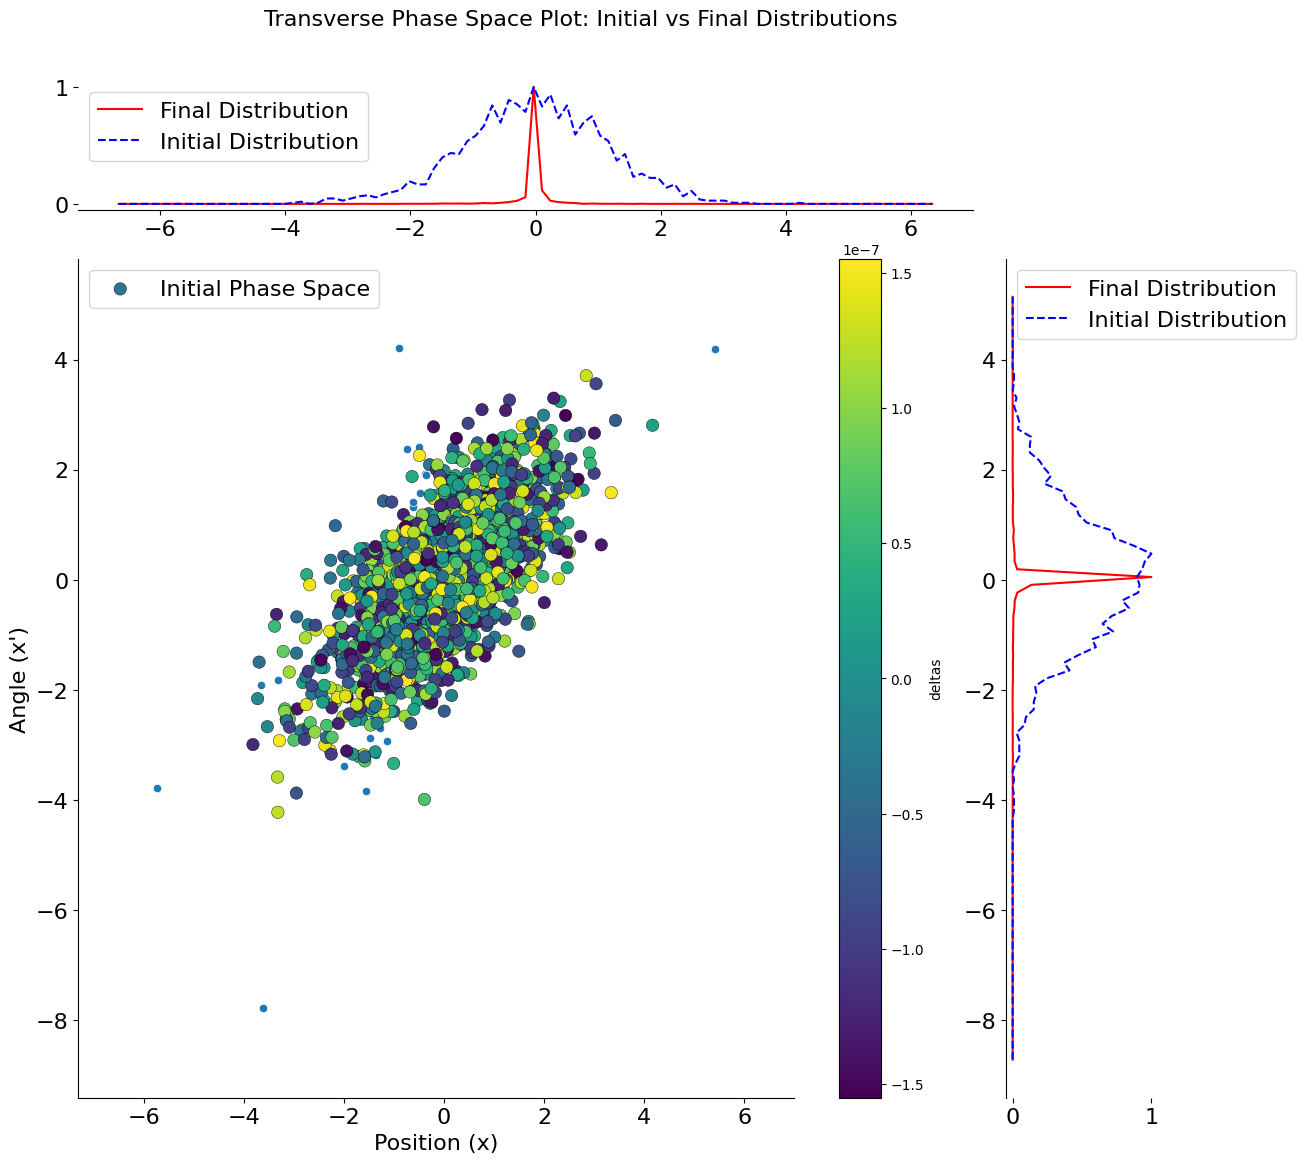

In [3]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import time
import scipy as sp
import seaborn as sns
import pandas as pd
from collections import OrderedDict


#time delay cooling here!~!!!!!1
#this approach -> bin centers main = only bin centers main
#also cut the time offset ->Th+Dtsamp+Tovlap

#datin  = time.time()  # record start time - to estimate run duration at end


Nparts, Nturns = 2000, 121
betPU, alfPU       =  1.3, -0.9
betK, alfK         =  0.8,  0.6

p_k_r53 = 0.4

gamPU, gamK        =  (1 + alfPU**2)/betPU, (1 + alfK**2)/betK
muPUK, muKPU       =  1.51, 2*np.pi*1.34 - 1.51
total_angle        =  2*np.pi*1.34
etaPUK, etaKPU     =  -0.01, -0.01     #eta PUK must be reletevely small, so they dont change slices so fast... 0.02 breaks the system ... It is the limit case!!!! very sensitive on etaPUK --> 2 much unwanted mixing, also etaKPU cant go very low(limit case 0.3) because then the mixing is bad
sigdelt            = 0.004         # rms momentum spread in unit
Th, Trev           =  (620.6e-9)/2, 620.6e-9 #the values now are the actual values of the AD #.1e-6,5e-6# half width of simulation window and revolution period in s
Tovlap, NSamp, add = 4*sigdelt*abs(etaPUK + etaKPU)*Trev, 2500, '2000'
gain               = 0.275 #s long as I reduce the eta, i have to reduce gains as well... see book
gainL              =  0
over_sample_factor = 10
#np.random.seed(54)

"""
wlH, wrH = -1.6e-9, 1.6e-9
def respH(Dt):
    if Dt < 1. * wlH or Dt > 1. * wrH:
        print(f' ===> function respH called with Dt ={1e6*Dt:8.4f}')
    return 0.5 * (1 + np.cos((2 * np.pi / wrH) * Dt))


"""
emittance_individual_particles = np.zeros((Nturns+2, 10))
# definition of the transverse "response function", which is given by the 
#    routine resp for the interval -wlH < Dt < wrH and 0 outside
wlH, wrH = -1.6e-9, 1.6e-9
def respH( Dt ):
   # if Dt < 1.*wlH or Dt > 1.*wrH:3
    #    print( f' ===> function respH called with Dt ={1e6*Dt:8.4f}' )
    return (1 - 27e18*Dt**2)*(1 - 3.e18*Dt**2)*(1 - 1.15e18*Dt**2)*(1 - (.625e9*Dt)**2)**7
#   return (1 - 23e16*Dt**2)*(1 - 3.e16*Dt**2)*(1 - 1.15e16*Dt**2)*(1 - (.625e8*Dt)**2)**7
#   return (1 - 25e-12*Dt^2)*(1 - 3e-12*Dt^2)*(1 - 1.15e-12*Dt^2)*(1 - (Dt/1.5)^2)^6

wlL, wrL = -1.6e-9, 1.6e-9
def respL( Dt ):
   # if Dt < 1.*wlL or Dt > 1.*wrL:
    #    print( f' ===> function respL called with Dt ={1e6*Dt:8.4f}' )
    return  (63e9*Dt)*(1 - 6.5e18*Dt**2)*(1 - 1.55e18*Dt**2)*(1 - (.625e9*Dt)**2)**8

#rng = np.random.default_rng(18022005)
rng = np.random.default_rng(22072458)   #this gives us the random seed!!!!

# Total width (particles of both colors) of beam time window is 2*Th ('h' for half)
#  for sampling each sub-window (red or blue) divided into NSamp intervals. This
#  means samp,ing rate DTsamp and NSamp + 1 points. On both ends to be added 
#  ceiling( Tovlap/DTSamp ) points   
DTSamp   = Th/NSamp
NSampext = math.ceil( Tovlap/DTSamp )
inds = np.arange( (-NSampext)*over_sample_factor , (NSamp+1+NSampext + 1)*over_sample_factor )
t_bins = inds*DTSamp/over_sample_factor -Th/2
avg_particles_per_bin = Nparts / (len(t_bins) - 1)
print('Sampling rate:', DTSamp, 's')
print('inds', len(inds))
print('Number of bins:', len(t_bins)-1, 'Average particles per bin:', avg_particles_per_bin)
print('========>', NSamp, NSampext, DTSamp, Th, (wrH - wlH)/DTSamp)

def running_average(x, y, bins):
    """
    Compute the running average of y over fixed intervals in x efficiently using NumPy.

    Parameters:
    x (array-like): Array of x-values (sorted or unsorted).
    y (array-like): Array of y-values corresponding to x.
    interval_width (float): The width of the intervals.

    Returns:
    bin_centers (numpy.ndarray): The centers of the bins.
    averages (numpy.ndarray): The average y-values for each bin.
    """
    # Ensure inputs are NumPy arrays
    x = np.array(x)
    y = np.array(y)

    # Bin the data using NumPy digitize
    bin_indices = np.digitize(x, bins) - 1  # Get zero-based bin indices

    # keep only elements within bins
    valid_input_indices = (bin_indices > 0) & (bin_indices < len(bins) - 1)

    # Preallocate array for averages
    averages = np.zeros(len(bins) - 1, dtype=float)
    
    # Use NumPy's bincount for fast bin-based summation and counts
    bin_sums   = np.bincount(bin_indices[valid_input_indices], minlength=len(bins) - 1, weights=y[valid_input_indices])
    bin_counts = np.bincount(bin_indices[valid_input_indices], minlength=len(bins) - 1)
    
    # Avoid division by zero: compute averages where bin_counts > 0
    non_empty_bins = bin_counts > 0
    averages[non_empty_bins] = bin_sums[non_empty_bins] / bin_counts[non_empty_bins]

    # Compute bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    return bin_centers, averages, bin_counts, bin_sums


def TimeTraces(ptsEarly, ptsMain, ptsLate, bins):
    """
    Generate time traces without applying the `Th / 2` offset internally.
    """
    
    ptsEarly = np.array(ptsEarly)
    ptsMain = np.array(ptsMain)
    ptsLate = np.array(ptsLate)
    # Compute histograms of beam distribution
    bin_centers_early, averages_early, count_early, sum_early = running_average(
        ptsEarly[:, 3]-Th, ptsEarly[:, 0], bins
    )
    bin_centers_main, averages_main, count_main, sum_main = running_average(
        ptsMain[:, 3], ptsMain[:, 0], bins
    )
    bin_centers_late, averages_late, count_late, sum_late = running_average(
        ptsLate[:, 3]+Th, ptsLate[:, 0], bins
    )



    # Total counts (number of particles in each bin)
    total_counts = count_early + count_main + count_late

# Mean number of particles per bin
    mean_count = np.mean(total_counts)

# Beam noise (variance of number of particles per bin)
    beam_noise = np.mean((total_counts - mean_count)**2)

    '''
    sum_early = sum_early.astype(float)
    sum_main  = sum_main.astype(float)
    sum_late  = sum_late.astype(float)
 

 
     # Add Gaussian noise (1% of RMS of the sum values)
    for sums in [sum_early, sum_main, sum_late]:
        rms_value = np.sqrt(np.mean(sums**2))
        noise = np.random.normal(0, 0.01 * rms_value, size=sums.shape)
        sums += noise



    count_early = count_early.astype(float)
    count_main  = count_main.astype(float)
    count_late  = count_late.astype(float)
 

 
     # Add Gaussian noise (1% of RMS of the sum values) i.e. electronic noise (longitudinal first, error in the time of flight)
    for counts in [count_early, count_main, count_late]:
        #rms_value = np.sqrt(np.mean(sums**2))
        rms_value = 0.095
        noise = np.random.normal(0,  rms_value, size=counts.shape)
        counts += noise
'''

    # Compute time traces
    TraceH_early = np.convolve(respH_new_once, sum_early, 'same')
    TraceH_main = np.convolve(respH_new_once, sum_main, 'same')
    TraceH_late = np.convolve(respH_new_once, sum_late, 'same')
    
    TraceL_early = np.convolve(respL_new_once, count_early, 'same')
    TraceL_main = np.convolve(respL_new_once, count_main, 'same')
    TraceL_late = np.convolve(respL_new_once, count_late, 'same')

    TraceH = TraceH_early + TraceH_main + TraceH_late
    TraceL = TraceL_early + TraceL_main + TraceL_late #i am multiplying with this factor in order to amplify the signal!!!!!
    
    
    
    return bin_centers_main, TraceH, TraceL, beam_noise

# Routine to do do the exchange of .. ended up by regrouping from scratch
def PartsExchange( ptsEarly, ptsLate ):
    ptsEarlyNew, ptsLateNew = [], []
    for x, xp, delt, Tau in ptsEarly:
        if Tau < Th/2:  # should remain in "early group
            ptsEarlyNew += [ [x, xp, delt, Tau] ]
        else:
            ptsLateNew += [ [x, xp, delt, Tau - Th] ]
    for x, xp, delt, Tau in ptsLate:
        if Tau > -Th/2:
            ptsLateNew += [ [x, xp, delt, Tau] ]
        else:
            ptsEarlyNew += [ [x, xp, delt, Tau + Th] ]
    return ptsEarlyNew, ptsLateNew

# Routine to generate time traces

'''
def TimeTraces( ptsEarly, ptsMain, ptsLate ):
    TraceH = [ 0. for _ in range(NSamp + 1 + 2*NSampext) ]
    TraceL = [ 0. for _ in range(NSamp + 1 + 2*NSampext) ]
#   first generate transverse trace
    for x, xp, delt, Tau in ptsEarly:    #precious slice than the one under investigation
        for ind in range( max(-NSampext, math.ceil((wlH+Tau-Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrH+Tau-Th+Th/2)/DTSamp)) ):
            TraceH[ind] += x*respH(ind*DTSamp -Th/2- (Tau-Th) )
    for x, xp, delt, Tau in ptsMain:     #slice under investigation
    for x, xp, delt, Tau in ptsLate:       #next slice un h) )
        for ind in range( max(-NSampext, math.ceil((wlH+Tau+Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrH+Tau+Th+Th/2)/DTSamp)) ):
            TraceH[ind] += x*respH(ind*DTSamp -Th/2- (Tau+Th) )
    for x, xp, delt, Tau in ptsEarly:
        for ind in range( max(-NSampext, math.ceil((wlL+Tau-Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrL+Tau-Th+Th/2)/DTSamp)) ):
            TraceL[ind] += respL(ind*DTSamp -Th/2- (Tau-Th) )
    for x, xp, delt, Tau in ptsMain:
        for ind in range( max(-NSampext, math.ceil((wlL+Tau+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrL+Tau+Th/2)/DTSamp)) ):
            TraceL[ind] += respL(ind*DTSamp -Th/2- Tau )
    for x, xp, delt, Tau in ptsLate:
        for ind in range( max(-NSampext, math.ceil((wlL+Tau+Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrL+Tau+Th+Th/2)/DTSamp)) ):
            TraceL[ind] += respL(ind*DTSamp -Th/2- (Tau+Th) )
    return TraceH, TraceL

'''

def kickH(pts, signalH):
    corrected_pts = []
    for x, xp, delt, Tau in pts:
        # Interpolate signalH at the particle's Tau
        signal_value = signalH(Tau)
        # Correct xp using the signal value (define your correction logic)
        corrected_xp = xp +gain * signal_value  # I add the signal!!!!!
        # Append the updated particle to the new list
        corrected_pts.append([x, corrected_xp, delt, Tau])
    return corrected_pts

def kickL(pts, signalL):
    corrected_pts = []
    for x, xp, delt, Tau in pts:
        # Interpolate signalL at the particle's Tau
        signal_value = signalL(Tau)
       
        # Correct xp using the signal value (define your correction logic)
        corrected_delt = delt + gainL * signal_value    # Example: subtracting scaled signal
        # Append the updated particle to the new list
        corrected_pts.append([x, xp, corrected_delt, Tau])
    return corrected_pts


snapshots = {}
respH_new_once = respH(np.arange(wlH, wrH, DTSamp/over_sample_factor ))
respL_new_once = respL(np.arange(wlL, wrL, DTSamp/over_sample_factor ))
# Computation of transverse transfer matrix elements
projPU11 =  betPU**(1/2)
projPU21 = -alfPU/betPU**(1/2)
projPU22 =  1/betPU**(1/2)

matPUK11 = ((betK/betPU)**(1/2))*(np.cos(muPUK) + alfPU*np.sin(muPUK))
matPUK12 = ((betPU*betK)**(1/2))*np.sin(muPUK)
matPUK21 = ((alfPU-alfK)*np.cos(muPUK) - (1+alfPU*alfK)*np.sin(muPUK))/((betPU*betK)**(1/2))
matPUK22 = ((betPU/betK)**(1/2))*(np.cos(muPUK) - alfK*np.sin(muPUK))

matKPU11 = ((betPU/betK)**(1/2))*(np.cos(muKPU) + alfK*np.sin(muKPU))
matKPU12 = ((betPU*betK)**(1/2))*np.sin(muKPU)
matKPU21 = ((alfK-alfPU)*np.cos(muKPU) - (1+alfPU*alfK)*np.sin(muKPU))/((betPU*betK)**(1/2))
matKPU22 = ((betK/betPU)**(1/2))*(np.cos(muKPU) - alfPU*np.sin(muKPU))

# Generate macroparticles in two groups with red ones and blue ones
#    .. say we start with red particles the early ones
ptsRed  = []
ptsBlue = []
for _ in range(Nparts):
    Tau = rng.uniform(-Th, Th)
    xn, xpn = rng.normal(0., 1.), rng.normal(0., 1.)
    deltn = rng.normal(0., 1.)
    while abs(deltn) > 3.:
        deltn = rng.normal(0., 1.)
    if Tau < 0: 
        ptsRed += [ [projPU11*xn, projPU21*xn + projPU22*xpn, 
                     deltn*sigdelt, Tau + Th/2] ]
    else:
        ptsBlue += [ [projPU11*xn, projPU21*xn + projPU22*xpn, 
                      deltn*sigdelt, Tau - Th/2] ]


emittance=np.zeros(Nturns+2)
geo_emittance=np.zeros(Nturns+2)
rms_momentum_spread=np.zeros(Nturns+2)
beam=[]
xp_beam=[]
x_beam=[]
beam=ptsRed+ptsBlue
beam = np.array(beam)
x_beam=beam[:,0]
xp_beam=beam[:,1]
x_initial=x_beam
xp_initial=xp_beam
tau_initial=beam[:,3]
delt_initial=beam[:,2]
counts_initial, bins_initial = np.histogram(delt_initial, bins=30)
emittance[0]=np.sqrt(np.mean(x_initial**2)*np.mean(xp_initial**2)-np.mean(x_initial*xp_initial)**2)   
geo_emittance[0]=((gamPU*np.mean(x_initial**2)+2*alfPU*np.mean(x_initial*xp_initial)+betPU*np.mean(xp_initial**2)))/2
#emittance_individual_particles[0][:]=(gamPU*x_beam[:10]**2+2*alfPU*(x_beam[:10]*xp_beam[:10])+betPU*(xp_beam[:10]**2))/2
rms_momentum_spread[0]=np.sqrt(np.mean(delt_initial**2)-np.mean(delt_initial)**2)


############################################################
## Track particles from pickup to kicker for the first time, 
## then to pickup again but without kicks. So everything is ready...
############################################################
ptsRedprev = ptsRed
ptsRed = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
            Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsRed ]  # no action at kicker
ptsRed = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
            Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsRed]
noise_of_all_beam=[]
# Prepare for tracking of blue particles and track them once around
ptsBlue, ptsRed = PartsExchange( ptsBlue, ptsRed )

ptsBlueprev = ptsBlue
time2,TrHBlue, TrLBlue,noise = TimeTraces( ptsRedprev, ptsBlue, ptsRed,t_bins )
noise_of_all_beam.append(noise)
ptsBlue = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
            Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsBlue ]  # no action at kicker
#ptsBlue=kickH(ptsBlue,cs)
ptsBlue = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
            Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsBlue]
TrHBlue_prev, TrLBlue_prev = TrHBlue, TrLBlue
# Prepare for 2nd tracking of red particles and track them once around
ptsRed, ptsBlue = PartsExchange( ptsRed, ptsBlue )
ptsRedprev = ptsRed

time2,TrHRed, TrLRed, noise = TimeTraces( ptsBlueprev, ptsRed, ptsBlue,t_bins )
#cs = sp.interpolate.CubicSpline( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
 #                 TrHRed[-NSampext:] + TrHRed[:NSamp + 1 + NSampext] )
noise_of_all_beam.append(noise)
ptsRed = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
            Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsRed ]  # no action at kicker
#ptsRed=kickH(ptsRed,cs)
ptsRed = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
            Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsRed]
TrHRed_prev, TrLRed_prev = TrHRed, TrLRed
# Now the blue ones are early - now just enter loop over number of turns
#   later - for longitudinal filter cooling - some more tracking will be needed

total_particles_in_beam = len(ptsRed) + len(ptsBlue)
unique_particles_in_traces = len(np.concatenate([
    ptsRedprev, ptsBlue, ptsRed
]))

print("Total particles in beam:", total_particles_in_beam)
print("Particles binned this turn:", unique_particles_in_traces)
beam=[]
xp_beam=[]
x_beam=[]
beam=ptsRed+ptsBlue
beam = np.array(beam)
x_beam=beam[:,0]
xp_beam=beam[:,1]
dtl_beam=beam[:,2]
emittance[1]=np.sqrt(np.mean(x_beam**2)*np.mean(xp_beam**2)-np.mean(x_beam*xp_beam)**2) 
#emittance_individual_particles[1][:]=(gamPU*x_beam[:10]**2+2*alfPU*(x_beam[:10]*xp_beam[:10])+betPU*(xp_beam[:10]**2))/2
rms_momentum_spread[1]=np.sqrt(np.mean(dtl_beam**2)-np.mean(dtl_beam)**2)


############################################################
## Start real simulation turn by turn, with cooling
############################################################


# Now we can go in loop and even implement transverse cooling or longitudinal time delay cooling (but not filter)
for turn in range(Nturns):
    #print(f' turn {turn:5d} after {(time.time() - datin):8.2f} s <===')
#   Get ready for the blue particles to be tracked and track them to kicker
    ptsBlue, ptsRed = PartsExchange( ptsBlue, ptsRed )
    ptsBlueprev, TrLBlueprev = ptsBlue, TrLBlue  # Keep longitudinal trace to add filter cooling later
    time2,TrHBlue, TrLBlue,noise = TimeTraces( ptsRedprev, ptsBlue, ptsRed,t_bins )
    noise_of_all_beam.append(noise)
    TrLDiffBlue = [h - l for h, l in zip(TrLBlue_prev, TrLBlue)]
    cs = sp.interpolate.CubicSpline( time2, 
                  TrHBlue )
    csL=sp.interpolate.CubicSpline( time2, 
                  np.array(TrLDiffBlue) )
    #cs = sp.interpolate.interp1d( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
     #             TrHBlue[-NSampext:] + TrHBlue[:NSamp + 1 + NSampext] )
    #csL=sp.interpolate.interp1d( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
     #             TrLBlue[-NSampext:] + TrLBlue[:NSamp + 1 + NSampext] )

    #print(len(TrHBlue))
    ptsBlue = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
                 Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsBlue ]
#   One day cooling to be applied -  now just dump time traces instead
    ptsBlue=kickH(ptsBlue,cs)
    ptsBlue=kickL(ptsBlue,csL)
#   track the blue one further to the PU
    #kicks = np.random.normal(loc=0, scale=0.005 * sigdelt, size=len(ptsRed))

    ptsBlue = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt,                     #+kick, 
                 Tau + etaKPU*delt*Trev] for (x, xp, delt, Tau) in ptsBlue] #    delt+kick,     for (x, xp, delt, Tau),kick in zip(ptsBlue,kicks)
    TrHBlue_prev, TrLBlue_prev = TrHBlue, TrLBlue
#   Get ready for the red particles to be tracked and track them to kicker
    ptsRed, ptsBlue = PartsExchange( ptsRed, ptsBlue )
    ptsRedprev, TrLRedprev = ptsRed, TrLRed  # Keep longitudinal trace to add filter cooling later
    time2,TrHRed, TrLRed,noise = TimeTraces( ptsBlueprev, ptsRed, ptsBlue,t_bins )
    noise_of_all_beam.append(noise)
    TrLDiffRed = [h - l for h, l in zip(TrLRed_prev, TrLRed)]
    cs = sp.interpolate.CubicSpline( time2, 
                  TrHRed )
    csL=sp.interpolate.CubicSpline( time2, 
                  np.array(TrLDiffRed) )
    
    y_cs = cs(time2)
    y_csL = csL(time2)
    #print("Spline Knots:", cs.x)  # Knots where the spline pieces join
    #print("Spline Coefficients:", cs.c)  # Coefficients of the spline pieces
   
    tauPU=[]
    xPU=[]
    beam=ptsRed
    beam = np.array(beam)
    tauPU=beam[:,3]
    xPU=beam[:,0]
    
    if turn==0:
     plt.figure(figsize=(8, 5))
     plt.plot(time2, y_cs, label="TrHRed Interpolated", linestyle="-")
     #plt.plot(t_smooth, y_csL, label="TrLDiffRed Interpolated", linestyle="--")
     plt.scatter(time2, TrHRed, marker="o", color="blue", label="horizontal signal")
     #plt.scatter(tauPU, xPU, zorder=5, color="red", label="position of particles")

    
# Plot the spline
    if turn==Nturns-1:
     plt.figure(figsize=(8, 5))
     plt.plot(time2, y_cs, label="TrHRed Interpolated", linestyle="-")
     #plt.plot(t_smooth, y_csL, label="TrLDiffRed Interpolated", linestyle="--")
     plt.scatter(time2, TrHRed, marker="o", color="blue", label="horizontal signal")
     #plt.scatter(tauPU, xPU, zorder=5, color="red", label="position of particles")

     
    ptsRed = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
                Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsRed ]
#   One day cooling(s) to be applied - now just dump time traces instead
    ptsRed=kickH(ptsRed,cs)
    ptsRed=kickL(ptsRed,csL)   #time of flight method longitudinal cooling
#   track the red ones further to the PU, where they will be the late ones

    #kicks = np.random.normal(loc=0, scale=0.005 * sigdelt, size=len(ptsRed))
    ptsRed = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt,         # +kick,
                Tau + etaKPU*delt*Trev] for (x, xp, delt, Tau) in ptsRed]  #    delt+kick,     for (x, xp, delt, Tau),kick in zip(ptsRed,kicks)
               
    TrHRed_prev, TrLRed_prev = TrHRed, TrLRed
    beam=[]
    xp_beam=[]
    x_beam=[]
    delta_beam=[]
    dlt_final=[]
    tau_final=[]
    beam=ptsRed+ptsBlue
    beam = np.array(beam)
    x_beam=beam[:,0]
    xp_beam=beam[:,1]
    delta_beam=beam[:,2]
    tau_final=beam[:,3]
    dlt_final=beam[:,2]
    counts_final, bins_final = np.histogram(dlt_final, bins=30)
    emittance[turn+2]=np.sqrt(np.mean(x_beam**2)*np.mean(xp_beam**2)-np.mean(x_beam*xp_beam)**2)
    geo_emittance[turn+2]=(gamPU*np.mean(x_beam**2)+2*alfPU*np.mean(x_beam*xp_beam)+betPU*np.mean(xp_beam**2))/2
    rms_momentum_spread[turn+2]=np.sqrt(np.mean(delta_beam**2)-np.mean(delta_beam)**2)
    #emittance_individual_particles[turn+2][:]=(gamPU*x_beam[:10]**2+2*alfPU*(x_beam[:10]*xp_beam[:10])+betPU*(xp_beam[:10]**2))/2
    if turn % 500 == 0:
        snapshots[turn] = dlt_final.copy() 

print(f'The initial emittance is {emittance[0]}{chr(0x03C0)} mm*mrad')
print(f'The final emittance after cooling is {emittance[-1]}{chr(0x03C0)} mm*mrad')
print(f'Is emittance reduced? -->  {emittance[-1] < emittance[0]}')
if emittance[-1] < emittance[0]:
  print(f"Emittance is reduced by {(emittance[0] - emittance[-1]) * 100 / emittance[0]}%")
print(f'The initial rms_momentum_spread is {rms_momentum_spread[0]} ')
print(f'The final rms_momentum_spread after cooling is {rms_momentum_spread[-1]} ')
print(f'Is rms_momentum_spread reduced? -->  {rms_momentum_spread[-1] < rms_momentum_spread[0]}')
if rms_momentum_spread[-1] < rms_momentum_spread[0]:
  print(f"rms_momentum_spread is reduced by {(rms_momentum_spread[0] - rms_momentum_spread[-1]) * 100 / rms_momentum_spread[0]}%")


#np.savetxt("beam_noise_values, 10000p NG=0.2.txt", noise_of_all_beam)

min_x = min(np.min(x_beam), np.min(x_initial))
max_x= max(np.max(x_beam), np.max(x_initial))
min_xp = min(np.min(xp_beam), np.min(xp_initial))
max_xp= max(np.max(xp_beam), np.max(xp_initial))
# Define more extended bin edges to ensure full coverage
bins_x = np.linspace(min_x - 1, max_x + 1, 100)  
bins_xp = np.linspace(min_xp - 1, max_xp + 1, 100)  
# Plot the jointplot

g = sns.jointplot(x=x_beam, y=xp_beam, kind="scatter", height=8, marginal_kws={'color': 'blue'})

# Initial phase space — lower zorder
g.ax_joint.scatter(x_initial, xp_initial, color='blue', s=30, label='Initial Phase Space', zorder=1)

# Final phase space — colored by delta
sc = g.ax_joint.scatter(x_beam, xp_beam, c=tau_final, cmap='viridis', s=80, edgecolor='black', linewidth=0.3,
                        label='Final Phase Space', zorder=2)

# Annotations
g.ax_joint.annotate('', (x_initial[0], xp_initial[0]), textcoords="offset points", xytext=(0, 10),
                    ha='center', color='blue', zorder=3)
g.ax_joint.annotate('', (x_beam[-1], xp_beam[-1]), textcoords="offset points", xytext=(0, 10),
                    ha='center', color='red', zorder=3)

# Colorbar for delta
plt.colorbar(sc, ax=g.ax_joint, label='taus')

# Optional: adjust margins if needed
plt.tight_layout()
'''
g = sns.jointplot(x=x_beam, y=xp_beam, kind="scatter", color="red", marginal_kws={'color': 'blue'})

# Plot initial phase space first (blue), lower zorder
g.ax_joint.scatter(x_initial, xp_initial, color='blue', s=10, label='Initial Phase Space', zorder=1)

# Plot final phase space after (red), higher zorder
g.ax_joint.scatter(x_beam, xp_beam, color='red', s=30, edgecolor='black', linewidth=0.5,
                   label='Final Phase Space', zorder=2)

# Annotate points
g.ax_joint.annotate('', (x_initial[0], xp_initial[0]), textcoords="offset points", xytext=(0, 10),
                    ha='center', color='blue', zorder=3)
g.ax_joint.annotate('', (x_beam[-1], xp_beam[-1]), textcoords="offset points", xytext=(0, 10),
                    ha='center', color='red', zorder=3)
'''
'''
# Add scatter points
g.ax_joint.scatter(x_beam, xp_beam, color='red', s=10, label='Final Phase Space')
g.ax_joint.scatter(x_initial, xp_initial, color='blue', s=10, label='Initial Phase Space')

# Annotate points
g.ax_joint.annotate('', (x_initial[0], xp_initial[0]), textcoords="offset points", xytext=(0, 10), ha='center', color='blue')
g.ax_joint.annotate('', (x_beam[-1], xp_beam[-1]), textcoords="offset points", xytext=(0, 10), ha='center', color='red')
'''
# Calculate histograms for x
hist_x_final, bin_edges_x_final = np.histogram(x_beam, bins=bins_x)
hist_x_initial, bin_edges_x_initial = np.histogram(x_initial, bins=bins_x)

# Calculate histograms for xp
hist_xp_final, bin_edges_xp_final = np.histogram(xp_beam, bins=bins_xp)
hist_xp_initial, bin_edges_xp_initial = np.histogram(xp_initial, bins=bins_xp)

# Smooth histograms
#hist_x_final = gaussian_filter1d(hist_x_final, sigma=2)
#hist_x_initial = gaussian_filter1d(hist_x_initial, sigma=2)
#hist_xp_final = gaussian_filter1d(hist_xp_final, sigma=2)
#hist_xp_initial = gaussian_filter1d(hist_xp_initial, sigma=2)

# Calculate bin centers for x
bin_centers_x = (bin_edges_x_final[:-1] + bin_edges_x_final[1:]) / 2

# Calculate bin centers for xp
bin_centers_xp = (bin_edges_xp_final[:-1] + bin_edges_xp_final[1:]) / 2

# Remove existing bars on the marginal axes
g.ax_marg_x.clear()
g.ax_marg_y.clear()
g.ax_joint.legend(loc='upper left', fontsize=16)
# Plot the smoothed marginal distributions as lines for x
g.ax_marg_x.plot(bin_centers_x, hist_x_final / max(hist_x_final), color='red', label='Final Distribution', linestyle='-')
g.ax_marg_x.plot(bin_centers_x, hist_x_initial / max(hist_x_initial), color='blue', label='Initial Distribution', linestyle='--')

# Plot the smoothed marginal distributions as lines for xp
g.ax_marg_y.plot(hist_xp_final / max(hist_xp_final), bin_centers_xp, color='red', label='Final Distribution', linestyle='-')
g.ax_marg_y.plot(hist_xp_initial / max(hist_xp_initial), bin_centers_xp, color='blue', label='Initial Distribution', linestyle='--')

# Add legends to marginal plots
g.ax_marg_x.legend(loc='upper left',fontsize=16)
g.ax_marg_y.legend(loc='upper left',fontsize=16)


g.ax_joint.tick_params(axis='both', labelsize=16)  # For joint axis
g.ax_marg_x.tick_params(axis='both', labelsize=16)  # For x marginal axis
g.ax_marg_y.tick_params(axis='both', labelsize=16)  # For y marginal axis
# Set axis labels
g.set_axis_labels('Position (x)', 'Angle (x\')', fontsize=16)

# Adjust the figure size and spacing
g.fig.set_size_inches(12, 12)
g.fig.subplots_adjust(top=0.92)

# Set a title
plt.suptitle('Transverse Phase Space Plot: Initial vs Final Distributions', fontsize=16)


fig, ( ax2,  ax4) = plt.subplots(
    2, 1, figsize=(15, 15)
)
'''
# First plot: Phase Space
ax1.scatter(x_initial, xp_initial, color='blue', s=2, label='First Element')
ax1.scatter(x_beam, xp_beam, color='red', s=2, label='Last Element')
ax1.annotate('First', (x_initial[0], xp_initial[0]), textcoords="offset points", xytext=(0, 10), ha='center', color='blue')
ax1.annotate('Last', 
             (x_beam[-1], xp_beam[-1]), 
             textcoords="offset points", 
             xytext=(0, 10), 
             ha='center', 
             color='red')

ax1.set_xlabel('Position (x)')
ax1.set_ylabel("Angle (x')")
ax1.set_title('Phase Space')
ax1.grid(True)
#ax1.set_aspect('equal', adjustable='box')

#ax1.set_xlim(min(x_initial.min(), x_beam.min()) - 0.5, max(x_initial.max(), x_beam.max()) + 0.5)
#ax1.set_ylim(min(xp_initial.min(), xp_beam.min()) - 0.5, max(xp_initial.max(), xp_beam.max()) + 0.5)

# Adjust axis limits to avoid overlap with histograms
ax1_hist_x = ax1.twiny()  # This creates a second x-axis for plotting x histogram
ax1_hist_x.hist(x_beam, bins=20, color='blue', alpha=0.3, label='Distribution of x', orientation='vertical')
ax1_hist_x.set_xlabel('Distribution of x')

# Histogram for xp (Angle) on ax1 (left)
ax1_hist_y = ax1.twinx()  # This creates a second y-axis for plotting xp histogram
ax1_hist_y.hist(xp_beam, bins=20, color='green', alpha=0.3, label='Distribution of xp', orientation='horizontal')
ax1_hist_y.set_ylabel('Distribution of xp')

# Adjust the placement of the histograms
ax1_hist_x.set_xlim(200)  # Match the x-limits of the phase space plot
ax1_hist_y.set_ylim(200)  # Match the y-limits of the phase space plot

# Add legends for histograms
ax1_hist_x.legend(loc='upper left')
ax1_hist_y.legend(loc='upper right')


# Add a legend

'''
# Second plot: Emittance vs Turns
pa = np.arange(0, Nturns ) * total_angle


# Plot RMS Emittance (Blue Curve)
ax2.plot(pa / total_angle*Trev, emittance[2:], label='RMS Emittance (Blue)', color='blue')

# Plot Geometric Emittance (Red Curve)
ax2.plot(pa / total_angle*Trev, geo_emittance[2:], label='Geometric Emittance (Red)', color='red')

# Add labels and title
ax2.set_xlabel('Time (sec)', fontsize=16)
ax2.set_ylabel('Emittance', fontsize=16)
ax2.set_title('Beam Emittance Over Turns', fontsize=16)
ax2.grid(True)
# Add a legend
ax2.legend(loc='upper right', fontsize=16)
gains_text = f"Gains:\nHorizontal Gain: {gain:.5f}\nLongitudinal Gain: {gainL}"
ax2.text(0.98, 0.75, gains_text,  # Adjust the y-coordinate to position below the legend
         transform=ax2.transAxes,  # Relative to the axes (0=left, 1=right)
         fontsize=12,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))  # Optional box for visibility

ax2.tick_params(axis='both', labelsize=14)
min_dlt = min(np.min(dlt_final), np.min(delt_initial))
max_dlt = max(np.max(dlt_final), np.max(delt_initial))

# Define more extended bin edges to ensure full coverage
bins_dlt = np.linspace(min_dlt - 0.0001, max_dlt + 0.0001, 100)  
#bins_dlt = np.histogram_bin_edges(dlt_final, bins=100)  # Customize bins as needed

# Plot the jointplot
g2 = sns.jointplot(x=tau_final, y=dlt_final, kind="scatter", color="red", marginal_kws={'color': 'blue'})

tau_final = np.array(tau_final)
dlt_final = np.array(dlt_final)

# Get indices of the 10 largest absolute values of dlt_final
top_indices = np.argsort(np.abs(dlt_final))[-16:]

# Add scatter points
g2.ax_joint.scatter(tau_final, dlt_final, color='red', s=10, label='Final Phase Space')
g2.ax_joint.scatter(tau_initial, delt_initial, color='blue', s=10, label='Initial Phase Space')

# Annotate points
g2.ax_joint.annotate('', (tau_initial[0], delt_initial[0]), textcoords="offset points", xytext=(0, 10), ha='center', color='blue')
g2.ax_joint.annotate('', (tau_final[-1], dlt_final[-1]), textcoords="offset points", xytext=(0, 10), ha='center', color='red')

# Calculate histograms for dlt (final and initial)
hist_final, bin_edges_final = np.histogram(dlt_final, bins=bins_dlt)
hist_initial, bin_edges_initial = np.histogram(delt_initial, bins=bins_dlt)

# Smooth the histograms using Gaussian filter
#hist_final_smooth = gaussian_filter1d(hist_final, sigma=2)
#hist_initial_smooth = gaussian_filter1d(hist_initial, sigma=2)

# Calculate bin centers
bin_centers = (bin_edges_final[:-1] + bin_edges_final[1:]) / 2

# Remove the marginal axis for tau
g2.ax_marg_x.remove()

# Clear existing bars on the marginal y-axis
g2.ax_marg_y.clear()
g2.ax_joint.legend(loc='upper left',fontsize=16)

# Plot the marginal distributions as smoothed lines for dlt
g2.ax_marg_y.plot(hist_final, bin_centers, color='red', label='Final Distribution', linestyle='-')
g2.ax_marg_y.plot(hist_initial, bin_centers, color='blue', label='Initial Distribution', linestyle='--')

# Add legend for the marginal plot
g2.ax_marg_y.legend(loc='upper left',fontsize=16)
g2.ax_joint.tick_params(axis='both', labelsize=16)  # For joint axis
g2.ax_marg_y.tick_params(axis='both', labelsize=16)  # For x marginal axis
# Set axis labels for joint plot
g2.set_axis_labels('Time (τ)', 'Momentum deviation δp/p (δ)', fontsize=16)
# Modify the x-axis scaling (scientific notation format) to make it more readable

# Adjust the figure size and spacing
g2.fig.set_size_inches(12, 12)
g2.fig.subplots_adjust(top=0.92)

# Set a title for the entire plot (super title for the whole figure)
plt.suptitle('Longitudinal Phase Space Plot: Initial vs Final Distributions', fontsize=16)

plt.subplots_adjust(hspace=19)




'''
ax3.scatter(tau_initial, delt_initial, color='blue', s=2, label='First Element')
ax3.scatter(tau_final, dlt_final, color='red', s=2, label='Last Element')
ax3.annotate('First', (tau_initial[0], delt_initial[0]), textcoords="offset points", xytext=(0, 10), ha='center', color='blue')
ax3.annotate('Last', (tau_final[-1], dlt_final[-1]), textcoords="offset points", xytext=(0, 10),ha='center', color='red')  
# Set axis labels and title for the scatter plot
'''


# Plot Geometric Emittance (Red Curve)
ax4.plot(pa / total_angle *Trev, rms_momentum_spread[2:]*1000, label='dp/p', color='red')

# Add labels and title
ax4.set_xlabel('Time (sec)', fontsize=16)
ax4.set_ylabel('RMS momentum_spread(milli)', fontsize=16)
ax2.set_title('Emittance Over Time', fontsize=16)
ax4.grid(True)
# Add a legend
ax4.legend(loc='upper right', fontsize=16)
N_text = f"Turns and particles:\nTurns: {Nturns}\nParticles: {Nparts}"
ax4.text(0.98, 0.75, N_text,  # Adjust the y-coordinate to position below the legend
         transform=ax4.transAxes,  # Relative to the axes (0=left, 1=right)
         fontsize=12,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))  # Optional box for visibility

ax4.tick_params(axis='both', labelsize=14)

# Define common bin edges

# Figure
fig, ax5 = plt.subplots(figsize=(12, 6))

# Common bins
all_dlt = np.concatenate([delt_initial, dlt_final] + list(snapshots.values()))
bins = np.linspace(np.min(all_dlt), np.max(all_dlt), 400)
bin_centers = bins[:-1] + 0.5 * np.diff(bins)
'''
# Initial distribution: navy bars
counts_initial, _ = np.histogram(delt_initial, bins=bins)
ax5.bar(
    bins[:-1], counts_initial, width=np.diff(bins),
    alpha=0.1, color='navy', label='Initial',
    align='edge', edgecolor='black', linewidth=1.5
)

# Final distribution: crimson bars on top
counts_final, _ = np.histogram(dlt_final, bins=bins)
ax5.bar(
    bins[:-1], counts_final, width=np.diff(bins),
    alpha=0.1, color='crimson', label=f'Final (Turn {Nturns})',
    align='edge', edgecolor='black', linewidth=1.2
)
'''
# Snapshots: thin, faded dashed lines
colors = plt.cm.plasma(np.linspace(0.15, 0.85, len(snapshots)))
for color, (turn, dlt_values) in zip(colors, sorted(snapshots.items())):
    counts, _ = np.histogram(dlt_values, bins=bins)
    ax5.plot(
        bin_centers, counts,
        linestyle='--', color=color,
        linewidth=1.2, alpha=0.1,  # lower alpha = more faded
        label=f'Turn {turn}'
    )
    # Optional: add markers on top of lines
    ax5.plot(
        bin_centers, counts,
        linestyle='', marker='o', markersize=4, color=color, alpha=0.5
    )

# Labels and title
ax5.set_xlabel(r'$\delta$ value', fontsize=12)
ax5.set_ylabel('Count', fontsize=12)
ax5.set_title(r'Evolution of $\delta$ Distribution, GN=0.2', fontsize=14)

# Remove duplicate legend entries by keeping first occurrence only
handles, labels = ax5.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

# Limit number of legend entries to max 8 for readability
max_legend = 8
handles_to_show = list(by_label.values())[:max_legend]
labels_to_show = list(by_label.keys())[:max_legend]
ax5.legend(handles_to_show, labels_to_show, fontsize=9)

ax5.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


'''
# Define common bin edges
fig, ax5 = plt.subplots(figsize=(12, 6))

# Common bins
all_dlt = np.concatenate([delt_initial, dlt_final] + list(snapshots.values()))
bins = np.linspace(np.min(all_dlt), np.max(all_dlt), 200)
bin_centers = bins[:-1] + 0.5 * np.diff(bins)
'''
'''
# Initial distribution: darker blue, less transparent, black edge
counts_initial, _ = np.histogram(delt_initial, bins=bins)
ax5.bar(
    bins[:-1], counts_initial, width=np.diff(bins),
    alpha=0.8, color='navy', label='Initial',
    align='edge', edgecolor='black', linewidth=1.2
)

# Final distribution: same as before
counts_final, _ = np.histogram(dlt_final, bins=bins)
ax5.bar(
    bins[:-1], counts_final, width=np.diff(bins),
    alpha=0.6, color='crimson', label=f'Final (Turn {Nturns})',
    align='edge', edgecolor='black', linewidth=1
)
'''
'''
# Snapshots as thick, vivid dashed lines, less transparent
colors = plt.cm.plasma(np.linspace(0.15, 0.85, len(snapshots)))
for color, (turn, dlt_values) in zip(colors, sorted(snapshots.items())):
    counts, _ = np.histogram(dlt_values, bins=bins)
    ax5.plot(
        bin_centers, counts,
        linestyle='--', color=color,
        linewidth=3, alpha=0.9,
        label=f'Turn {turn}'
    )

# Labels and title
ax5.set_xlabel(r'$\delta$ value', fontsize=12)
ax5.set_ylabel('Count', fontsize=12)
ax5.set_title(r'Evolution of $\delta$ Distribution, GN=0.2', fontsize=14)

# Remove duplicate legend entries by keeping first occurrence only
handles, labels = ax5.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
# Limit number of legend entries to max 8 for readability
max_legend = 8
handles_to_show = list(by_label.values())[:max_legend]
labels_to_show = list(by_label.keys())[:max_legend]
ax5.legend(handles_to_show, labels_to_show, fontsize=9)
ax5.grid(True, linestyle='--', alpha=0.5)

plt.subplots_adjust(hspace=0.4, bottom=0.15)
plt.tight_layout()
plt.show()
'''
'''
fig, ax6 = plt.subplots(figsize=(12, 6))
ax6.bar(bins_initial[:-1], counts_initial, width=np.diff(bins_initial), 
        alpha=0.6, color='b', label='Initial', align='edge')

ax6.bar(bins_final[:-1], counts_final, width=np.diff(bins_final), 
        alpha=0.6, color='r', label='Final', align='edge')

# Add labels, title, and legend
ax6.set_xlabel("Value")
ax6.set_ylabel("Count")
ax6.set_title("Comparison of Initial and Final delta distribution")
'''



min_x = min(np.min(x_beam), np.min(x_initial))
max_x= max(np.max(x_beam), np.max(x_initial))
min_xp = min(np.min(xp_beam), np.min(xp_initial))
max_xp= max(np.max(xp_beam), np.max(xp_initial))
# Define more extended bin edges to ensure full coverage
bins_x = np.linspace(min_x - 1, max_x + 1, 100)  
bins_xp = np.linspace(min_xp - 1, max_xp + 1, 100)  
# Plot the jointplot

g = sns.jointplot(x=x_beam, y=xp_beam, kind="scatter", height=8, marginal_kws={'color': 'blue'})

# Initial phase space — lower zorder
g.ax_joint.scatter(x_initial, xp_initial, c=tau_initial, cmap='viridis', s=80, edgecolor='black', label='Initial Phase Space',linewidth=0.3, zorder=2)

# Final phase space — colored by delta
#sc = g.ax_joint.scatter(x_beam, xp_beam, c=dlt_final, cmap='viridis', s=80, edgecolor='black', linewidth=0.3,
                       # label='Final Phase Space', zorder=2)

# Annotations
g.ax_joint.annotate('', (x_initial[0], xp_initial[0]), textcoords="offset points", xytext=(0, 10),
                    ha='center', color='blue', zorder=3)
g.ax_joint.annotate('', (x_beam[-1], xp_beam[-1]), textcoords="offset points", xytext=(0, 10),
                    ha='center', color='red', zorder=3)

# Colorbar for delta
plt.colorbar(sc, ax=g.ax_joint, label='deltas')

# Optional: adjust margins if needed
plt.tight_layout()
'''
g = sns.jointplot(x=x_beam, y=xp_beam, kind="scatter", color="red", marginal_kws={'color': 'blue'})

# Plot initial phase space first (blue), lower zorder
g.ax_joint.scatter(x_initial, xp_initial, color='blue', s=10, label='Initial Phase Space', zorder=1)

# Plot final phase space after (red), higher zorder
g.ax_joint.scatter(x_beam, xp_beam, color='red', s=30, edgecolor='black', linewidth=0.5,
                   label='Final Phase Space', zorder=2)

# Annotate points
g.ax_joint.annotate('', (x_initial[0], xp_initial[0]), textcoords="offset points", xytext=(0, 10),
                    ha='center', color='blue', zorder=3)
g.ax_joint.annotate('', (x_beam[-1], xp_beam[-1]), textcoords="offset points", xytext=(0, 10),
                    ha='center', color='red', zorder=3)
'''
'''
# Add scatter points
g.ax_joint.scatter(x_beam, xp_beam, color='red', s=10, label='Final Phase Space')
g.ax_joint.scatter(x_initial, xp_initial, color='blue', s=10, label='Initial Phase Space')

# Annotate points
g.ax_joint.annotate('', (x_initial[0], xp_initial[0]), textcoords="offset points", xytext=(0, 10), ha='center', color='blue')
g.ax_joint.annotate('', (x_beam[-1], xp_beam[-1]), textcoords="offset points", xytext=(0, 10), ha='center', color='red')
'''
# Calculate histograms for x
hist_x_final, bin_edges_x_final = np.histogram(x_beam, bins=bins_x)
hist_x_initial, bin_edges_x_initial = np.histogram(x_initial, bins=bins_x)

# Calculate histograms for xp
hist_xp_final, bin_edges_xp_final = np.histogram(xp_beam, bins=bins_xp)
hist_xp_initial, bin_edges_xp_initial = np.histogram(xp_initial, bins=bins_xp)

# Smooth histogramsH
#hist_x_initial = gaussian_filter1d(hist_x_initial, sigma=2)
#hist_xp_final = gaussian_filter1d(hist_xp_final, sigma=2)
#hist_xp_initial = gaussian_filter1d(hist_xp_initial, sigma=2)

# Calculate bin centers for x
bin_centers_x = (bin_edges_x_final[:-1] + bin_edges_x_final[1:]) / 2

# Calculate bin centers for xp
bin_centers_xp = (bin_edges_xp_final[:-1] + bin_edges_xp_final[1:]) / 2

# Remove existing bars on the marginal axes
g.ax_marg_x.clear()
g.ax_marg_y.clear()
g.ax_joint.legend(loc='upper left', fontsize=16)
# Plot the smoothed marginal distributions as lines for x
g.ax_marg_x.plot(bin_centers_x, hist_x_final / max(hist_x_final), color='red', label='Final Distribution', linestyle='-')
g.ax_marg_x.plot(bin_centers_x, hist_x_initial / max(hist_x_initial), color='blue', label='Initial Distribution', linestyle='--')

# Plot the smoothed marginal distributions as lines for xp
g.ax_marg_y.plot(hist_xp_final / max(hist_xp_final), bin_centers_xp, color='red', label='Final Distribution', linestyle='-')
g.ax_marg_y.plot(hist_xp_initial / max(hist_xp_initial), bin_centers_xp, color='blue', label='Initial Distribution', linestyle='--')

# Add legends to marginal plots
g.ax_marg_x.legend(loc='upper left',fontsize=16)
g.ax_marg_y.legend(loc='upper left',fontsize=16)


g.ax_joint.tick_params(axis='both', labelsize=16)  # For joint axis
g.ax_marg_x.tick_params(axis='both', labelsize=16)  # For x marginal axis
g.ax_marg_y.tick_params(axis='both', labelsize=16)  # For y marginal axis
# Set axis labels
g.set_axis_labels('Position (x)', 'Angle (x\')', fontsize=16)

# Adjust the figure size and spacing
g.fig.set_size_inches(12, 12)
g.fig.subplots_adjust(top=0.92)

# Set a title
plt.suptitle('Transverse Phase Space Plot: Initial vs Final Distributions', fontsize=16)



print("Indices of the 10 particles with the largest |δ|:", top_indices)

# Optionally, print the corresponding tau and dlt values
print("Corresponding (τ, δ) values:")
for i in top_indices:
    print(f"Index {i}: (τ = {tau_final[i]}, δ = {dlt_final[i]})")


data_to_save = emittance

# Define path and filename
output_dir = os.path.expanduser("~/2409/scooling/studies/final results")
output_file = os.path.join(output_dir, "emittance for 2000 particles,NG= 550.txt")

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Save data
np.savetxt(output_file, data_to_save)


# Show the plot
#ax5.show()

#print(f'\n\n =======> duration of run{(time.time() - datin):8.2f} s <===\n')

#print(f"Memory usage after operations: {process.memory_info().rss / 1e6} MB")

#print(f'\n\n =======> duration of run{(time.time() - datin):8.2f} s <===\n')